## Импорт необходимых библиотек

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

## Конфигурация PyTorch

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA devices: {torch.cuda.device_count()}")
print(f"Current CUDA device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA devices: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 4070


## Конфигурация модели

In [8]:
# Конфигурация
DATA_PATH = "dataset"
BATCH_SIZE = 16
EPOCHS = 10
LR = 0.001
IMG_SIZE = 256

## Класс, описывающий датасет

In [9]:
# Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        
        self.empty_indices = []
        self.non_empty_indices = []
        
        for idx, img_name in enumerate(self.images):
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = np.array(Image.open(mask_path).convert("L"))
            if np.all(mask == 0):
                self.empty_indices.append(idx)
            else:
                self.non_empty_indices.append(idx)
        
        print(f"Total: {len(self.images)} images")
        print(f"Mask statistics: {len(self.empty_indices)} empty, {len(self.non_empty_indices)} non-empty")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

## Аугментация данных

In [10]:
# Аугментация
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])


## Загрузка датасета

In [11]:
# Загрузка полного датасета
full_dataset = SegmentationDataset(
    image_dir=os.path.join(DATA_PATH, "images"),
    mask_dir=os.path.join(DATA_PATH, "masks"),
    transform=transform
)

Total: 17408 images
Mask statistics: 13435 empty, 3973 non-empty


## Балансировка классов

In [12]:
# Создание сбалансированного списка индексов
empty = full_dataset.empty_indices
non_empty = full_dataset.non_empty_indices
random.shuffle(empty)
random.shuffle(non_empty)

min_count = min(len(empty), len(non_empty))
balanced_indices = empty + non_empty
random.shuffle(balanced_indices)

## Разделение на обучающую и тестовую выборку, загрузка данных

In [13]:
# Разделение на обучающую и тестовую выборку
split_idx = int(0.8 * len(balanced_indices))
train_indices = balanced_indices[:split_idx]
test_indices = balanced_indices[split_idx:]

train_subset = Subset(full_dataset, train_indices)
test_subset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE)

## Функция по расчету необходимых метрик

In [14]:
# Метрики
def calculate_metrics(outputs, masks, threshold=0.5):
    outputs = (outputs > threshold).float()
    masks = (masks > 0.5).float()
    batch_ious, batch_dices = [], []

    for i in range(outputs.shape[0]):
        output = outputs[i]
        mask = masks[i]
        intersection = (output * mask).sum()
        union = (output + mask).sum() - intersection
        total = output.sum() + mask.sum()
        iou = (intersection / union).item() if union != 0 else float(output.sum() == 0 and mask.sum() == 0)
        dice = (2. * intersection / total).item() if total != 0 else 1.0
        batch_ious.append(iou)
        batch_dices.append(dice)

    return np.mean(batch_ious), np.mean(batch_dices)

## DeepLabv3+

In [15]:
# Адаптированная модель DeepLabV3+
class SmallDeepLabV3Plus(nn.Module):
    def __init__(self, num_classes=1):
        super(SmallDeepLabV3Plus, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet18.children())[:-2])
        
        self.aspp = self._create_aspp(in_channels=512, out_channels=256)
        
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, num_classes, kernel_size=1)
        )

    def _create_aspp(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        features = self.backbone(x)
        
        aspp_features = self.aspp(features)
        
        decoder_output = self.decoder(aspp_features)
        
        output = nn.functional.interpolate(decoder_output, size=x.shape[2:], mode="bilinear", align_corners=False)
        return output


## Обучение модели

In [16]:
# Обучение
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallDeepLabV3Plus(num_classes=1).to(device)
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

train_losses, test_losses, ious, dices = [], [], [], []
best_iou = -1

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    model.eval()
    test_loss = 0
    epoch_ious, epoch_dices = [], []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, masks).item()
            batch_iou, batch_dice = calculate_metrics(outputs, masks)
            epoch_ious.append(batch_iou)
            epoch_dices.append(batch_dice)

    avg_iou = np.mean(epoch_ious)
    avg_dice = np.mean(epoch_dices)
    avg_test_loss = test_loss / len(test_loader)

    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(avg_test_loss)
    ious.append(avg_iou)
    dices.append(avg_dice)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")
    print(f"IoU: {ious[-1]:.4f} | Dice: {dices[-1]:.4f}")
    print("------------------------")
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(model.state_dict(), "small_deeplabv3.pth")
        print(f"Best model saved at epoch {epoch+1} with IoU: {avg_iou:.4f}")


Epoch 1/10
Train Loss: 0.4834 | Test Loss: 0.4921
IoU: 0.7330 | Dice: 0.7450
------------------------
Best model saved at epoch 1 with IoU: 0.7330
Epoch 2/10
Train Loss: 0.4566 | Test Loss: 0.4948
IoU: 0.7376 | Dice: 0.7474
------------------------
Best model saved at epoch 2 with IoU: 0.7376
Epoch 3/10
Train Loss: 0.4511 | Test Loss: 0.4897
IoU: 0.7742 | Dice: 0.7742
------------------------
Best model saved at epoch 3 with IoU: 0.7742
Epoch 4/10
Train Loss: 0.4455 | Test Loss: 0.4215
IoU: 0.7518 | Dice: 0.7583
------------------------
Epoch 5/10
Train Loss: 0.4451 | Test Loss: 0.4216
IoU: 0.7742 | Dice: 0.7742
------------------------
Best model saved at epoch 5 with IoU: 0.7742
Epoch 6/10
Train Loss: 0.4386 | Test Loss: 0.5132
IoU: 0.7362 | Dice: 0.7486
------------------------
Epoch 7/10
Train Loss: 0.4361 | Test Loss: 0.5596
IoU: 0.7405 | Dice: 0.7526
------------------------
Epoch 8/10
Train Loss: 0.4348 | Test Loss: 0.4265
IoU: 0.7440 | Dice: 0.7559
------------------------
Epoc

## Метрики

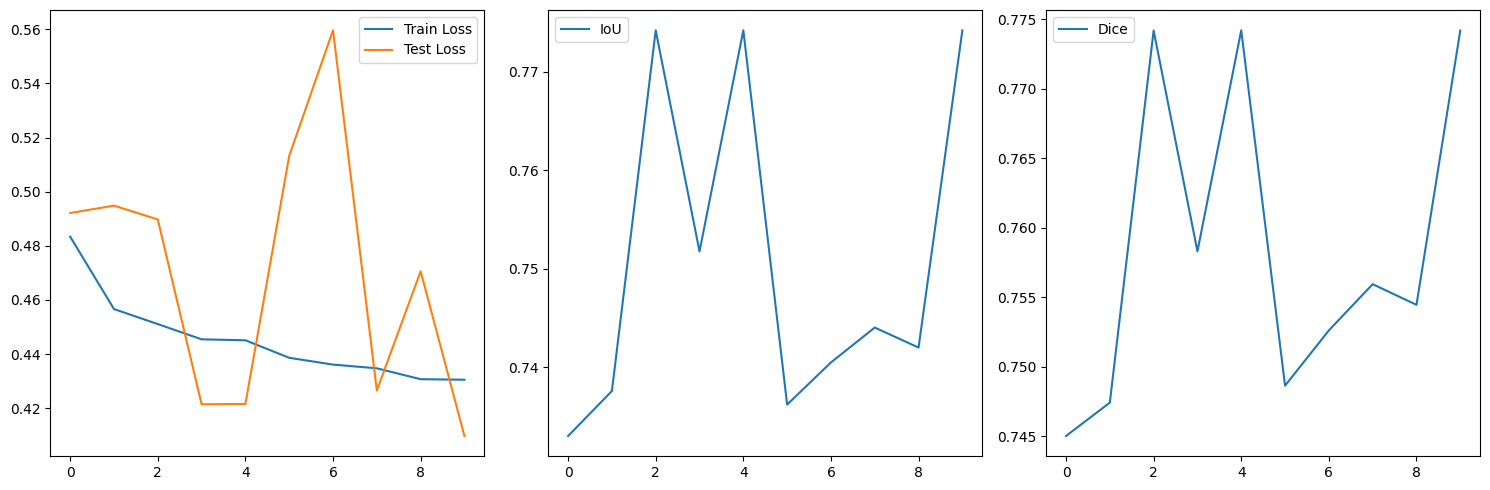

In [17]:
# Графики
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.subplot(132)
plt.plot(ious, label='IoU')
plt.legend()
plt.subplot(133)
plt.plot(dices, label='Dice')
plt.legend()
plt.tight_layout()
plt.show()